## Model Predictive Control (MPC) of a CSTR (Continuous Stirred Tank Reactor)

The MPC formulation can be written as following
$$\begin{equation}
    \begin{aligned}
    \min_{u_k} \quad &  \sum_{k=0}^{T-1} J \left( x_k, u_k \right)\\
    \text{subject to} \quad & \dot{x}(t) = f(t, x(t), {u(t)})\\
    &x(0) = x_0\\
    & t \in \mathcal{T}
    \end{aligned}
\end{equation}$$
where $J$ is a cost function and $T \in \mathcal{T}$ is the _receding horizon_ over which predicted future trajectories are optimized

In [307]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append(2*'../') # go n dirs back
import matplotlib.pyplot as plt

import torch
from torchcontrol.systems import CSTR
from torchcontrol.cost import IntegralCost
from torchcontrol.controllers import *
from torchcontrol.mpc import TorchMPC
from torchcontrol.plotting import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The quadcopter model is a suitably modified version of the explicit dynamics update of the library [do-mpc](https://www.do-mpc.com/en/latest/example_gallery/CSTR.html) for batched training in PyTorch. The following accelerations update describes the dynamic model
$$\begin{align}
\dot{C}_{\text{A}} &= F \cdot (C_{\text{A},0} - C_{\text{A}}) - k_1 \cdot C_{\text{A}} - k_3 \cdot C_{\text{A}}^2, \\
\dot{C}_{\text{B}} &= F \cdot C_{\text{B}} + k_1 \cdot C_{\text{A}} - k_2 \cdot C_{\text{B}}, \\
\dot{T}_{\text{R}} &= \frac{k_1 \cdot C_{\text{A}} \cdot H_{\text{R},ab} + k_2 \cdot C_{\text{B}} \cdot  H_{\text{R},bc} + k_3 \cdot C_{\text{A}}^2 \cdot H_{\text{R},ad}} {-\rho \cdot c_p}\\
&+ F \cdot (T_{\text{in}} - T_{\text{R}}) + \frac{K_w \cdot A_{\text{R}} \cdot(T_{\text{K}}-T_{\text{R}})}{\rho \cdot c_p \cdot V_{\text{R}}}, \\
\dot{T}_{\text{K}} &= \frac{\dot{Q} + k_w \cdot A_{\text{R}} \cdot T_{\text{dif}}}{m_k \cdot C_{p,k}},
\end{align}$$

where

$$\begin{align}
k_1 &= \beta \cdot k_{0,\text{ab}} \cdot \exp\left(\frac{-E_{\text{A},\text{ab}}}{T_{\text{R}}+273.15}\right), \\
k_1 &= k_{0,\text{bc}} \cdot \exp \left( \frac{-E_{\text{A},\text{bc}}}{T_{\text{R}}+273.15} \right), \\
k_3 &= k_{0,\text{ad}} \cdot \exp \left( \frac{-\alpha \cdot E_{\text{A},\text{ad}}}{T_{\text{R}}+273.15} \right).
\end{align}$$

In [308]:
?? CSTR

Init signature:  CSTR(*args, alpha=1, beta=1, **kwargs)
Source:        
class CSTR(ControlledSystemTemplate):
    '''
    Controlled Continuous Stirred Tank Reactor
    Reference: https://www.do-mpc.com/en/latest/example_gallery/CSTR.html
    '''
    def __init__(self, *args, alpha=1, beta=1, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Parameters
        self.α = alpha # empirical parameter, may vary
        self.β = beta # empirical parameter, may vary
        self.K0_ab = 1.287e12 # K0 [h^-1]
        self.K0_bc = 1.287e12 # K0 [h^-1]
        self.K0_ad = 9.043e9 # K0 [l/mol.h]
        self.R_gas = 8.3144621e-3 # Universal gas constant
        self.E_A_ab = 9758.3*1.00 #* R_gas# [kj/mol]
        self.E_A_bc = 9758.3*1.00 #* R_gas# [kj/mol]
        self.E_A_ad = 8560.0*1.0 #* R_gas# [kj/mol]
        self.H_R_ab = 4.2 # [kj/mol A]
        self.H_R_bc = -11.0 # [kj/mol B] Exothermic
        self.H_R_ad = -41.85 # [kj/mol A] Exothermic
        self.Rou = 0.9342

In [309]:
# Change device according to your configuration
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') # feel free to change :)
device = torch.device('cpu') # override

## Cost function
We want the CSTR to reach a concentration of $C_b^\star = 0.6$, while also minimizing the energy consumption and satisfying state boundaries

Note: finding good values for the cost function is hard - many times, it requires patience and lots of trials and error

In [310]:
# Declaring the cost function
x_star = torch.Tensor([0, 0.6, 0, 0]).to(device) # the zeros are dummy values
u_star = torch.Tensor([5, 0]) # Least expensive controller values

P = torch.Tensor([0, 1, 0, 0]).to(device)
Q = torch.Tensor([0, .1, 0, 0]).to(device)
R = torch.Tensor([1e-3, 1e-4]).to(device)
cost_function = IntegralCost(x_star=x_star, u_star=u_star, P=P, Q=Q, R=R)

## Initial Conditions
We start with all the variables at 0

In [311]:
# Initial Conditions
ε = .01 # 1% of uncertainty given initial conditions
C_a_0 = 0.8 # This is the initial concentration inside the tank [mol/l]
C_b_0 = 0.5 # This is the controlled variable [mol/l]
T_R_0 = 134.14 #[C]
T_K_0 = 130.0 #[C]
init = torch.Tensor([C_a_0, C_b_0, T_R_0, T_K_0]).to(device)
print(init)

tensor([  0.8000,   0.5000, 134.1400, 130.0000])


## Scaling

In [312]:
##### Scaling since the parameters have very different values
scaling_T_R = 1/100
scaling_T_K = 1/100
scaling_Q_dot = 1/2000
scaling_F = 1/100

# Scale the inputs appropriately for the controller
in_scal = torch.ones(4).to(device)
in_scal[2] = scaling_T_R
in_scal[3] = scaling_T_K
print('Input scaling:\n', in_scal)

out_scal = torch.tensor([[5.,  100.],
                        [-8500, 0.]]).to(device)
print('Output scaling:\n', out_scal)

Input scaling:
 tensor([1.0000, 1.0000, 0.0100, 0.0100])
Output scaling:
 tensor([[ 5.0000e+00,  1.0000e+02],
        [-8.5000e+03,  0.0000e+00]])


## Controller
We use the neural box-constrained controller with input and output scaling due to the differences in magnitude

In [313]:
# Instantiate drone
cstr = CSTR(None, solver='euler') # dummy controller
controller = BoxConstrainedController(4, 2, input_scaling=in_scal, output_scaling=out_scal, constrained=True)
cstr.u = controller # controller for the drone

## Constraints
Since we have constraints on the states, we introduce penalties for out-of-bounds states

In [314]:

# State constraints
lower_bounds = [0.1, 0.1, 50., 50.]
upper_bounds = [2., 2., None, 140.]
penalties =  0.1*torch.ones(4); penalties[3] = 100
print('Lower bounds:\n', lower_bounds, '\nUpper bounds:\n', upper_bounds)

Lower bounds:
 [0.1, 0.1, 50.0, 50.0] 
Upper bounds:
 [2.0, 2.0, None, 140.0]


## MPC initialization

In [315]:
# MPC simulation variables
Δt = 0.005
t0, tf = 0, 0.2
t_span = torch.linspace(t0, tf, int(tf/Δt) + 1).to(device) # define the t span

# MPC simulation variables
steps_nom = 10 # Nominal steps to do between each MPC step
max_iters = 50
eps_accept = 3e-3 # so we 'fix' the iterations to be always maximum
lookahead_steps = 10
lr = 1e-3
weight_decay = 1e-4 # weight decay for adam
x0 = init # initial condition

# Optimizer
opt = torch.optim.Adam(controller.parameters(), lr=lr, weight_decay=weight_decay)

# Instantiate MPC
mpc = TorchMPC(cstr, cost_function, t_span, opt, eps_accept=eps_accept, max_g_iters=max_iters,
            lookahead_steps=lookahead_steps, lower_bounds=lower_bounds,
            upper_bounds=upper_bounds, penalties=penalties).to(device)

## MPC simulation
For simulating the MPC we need a system with an accurate solver, e.g. `dopri5` for carrying forward the solutions

In [316]:
cstr_nominal = CSTR(RandConstController((1,1),1,1), solver='dopri5', atol=1e-5, rtol=1e-5)
loss = mpc.forward_simulation(cstr_nominal, x0, t_span, reset=False, reinit_zeros=False)

Steps:   0%|          | 0/40 [00:00<?, ?it/s]

Starting simulation...


Steps: 100%|██████████| 40/40 [00:18<00:00,  2.18it/s, cost=0.434, timestamp=0.2, converged=0]

The simulation has ended!


In [317]:
# Get variables
traj = mpc.trajectory_nominal
controls = mpc.control_inputs 
print('Nominal cost:', loss)

Nominal cost: tensor(0.3903)


## Plotting

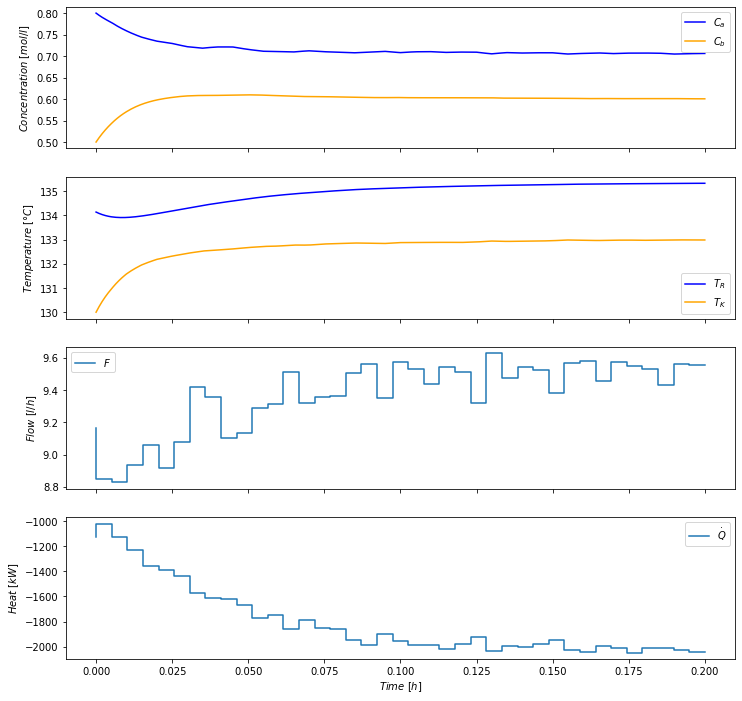

In [318]:
plot_cstr_trajectories_controls(traj, controls, tf=tf)